![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [2]:
# QuantBook Analysis Tool 
# For more information see [https://www.quantconnect.com/docs/research/overview]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import api as smg

qb = QuantBook()
start_time = datetime(2020, 1, 1) # start datetime for history call
end_time = datetime(2020, 12, 1) # end datetime for history call

In [3]:
    #Dickey-Fuller test stolen from https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/
    def ADF_Stationarity_Test(timeseries, significance_level=0.05, printResults = True):
        is_stationary = None
        
        adf_test = adfuller(timeseries, autolag='AIC')
        pValue = adf_test[1]
        
        if (pValue<significance_level):
            is_stationary = True
        else:
            is_stationary = False
        
        if printResults:
            dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adf_test[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            print('Is it stationary? '+str(is_stationary))
        else:
            return is_stationary

symbol       time               
WTICOUSD 8I  2016-04-21 20:00:00    41.9855
             2016-04-22 20:00:00    42.2930
             2016-04-24 20:00:00    42.0775
             2016-04-25 20:00:00    41.6465
             2016-04-26 20:00:00    43.2855
Name: close, dtype: float64
symbol       time               
WTICOUSD 8I  2020-12-15 19:00:00    47.500
             2020-12-16 19:00:00    47.788
             2020-12-17 19:00:00    48.310
             2020-12-18 19:00:00    49.023
             2020-12-20 19:00:00    48.370
Name: close, dtype: float64
1461


/opt/miniconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Crude Oil'}, xlabel='symbol,time'>

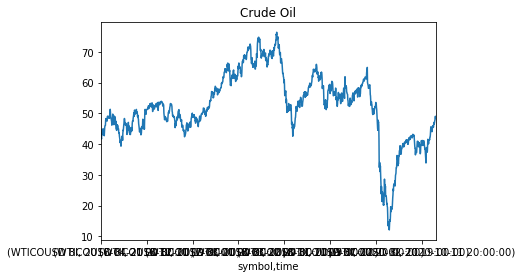

In [18]:
oil = qb.AddCfd("WTICOUSD", Resolution.Daily, Market.Oanda)
oil_data = qb.History(["WTICOUSD"], 4*365, Resolution.Daily)
print(oil_data['close'].head())
print(oil_data['close'].tail())
print(oil_data['close'].size)
oil_data['close'].plot(title='Crude Oil')

In [ ]:
print('Running Augmented Dickey-Fuller Test for Crude Oil...\n')
ADF_Stationarity_Test(oil_data['close'].values)

In [5]:
# create a differenced series
def difference(series, interval=1):
    diff = []
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return diff

Making data stationary...



<AxesSubplot:title={'center':'Stationary Crude Oil'}>

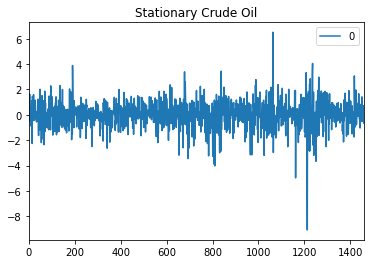

In [6]:
print('Making data stationary...\n')
stationary_oil_data = pd.DataFrame(difference(oil_data['close']))
stationary_oil_data.plot(title='Stationary Crude Oil')

In [ ]:
print('Running Augmented Dickey-Fuller Test for Stationary Crude Oil...\n')
ADF_Stationarity_Test(stationary_oil_data.values)

In [ ]:
# Auto correlation test on raw data
auto_corr_oil = plot_acf(oil_data['close'].values)
auto_corr_oil.show()

In [ ]:
# Partial auto correlation test on raw data
part_auto_corr = plot_pacf(oil_data['close'].values)
part_auto_corr.show()

Checking ARIMA(1,1,7)


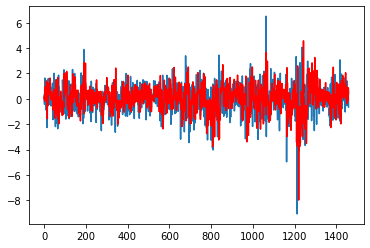

In [9]:
print('Checking ARIMA(1,1,7)')

model = sm.tsa.arima_model.ARIMA(oil_data['close'].values, order=(1, 1, 7))
res = model.fit()
plt.plot(stationary_oil_data)
plt.plot(res.fittedvalues*8, color='red')